In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/w266')

In [44]:
import re
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from transformers import AutoTokenizer,TFAutoModel,TFAutoModelForSequenceClassification
from transformers import logging
logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix

tf.random.set_seed(66)

# Load Data

In [5]:
news=pd.read_csv('reuters_news_2006_2013.csv').dropna()
news.shape

(105343, 3)

In [6]:
news['date']=pd.to_datetime(news['date'],format="%Y%m%d")

In [7]:
news.head()

,date,title,summary
0,2006-11-13,"Hitachi, GE boost alliance in nuclear power bu...",TOKYO (Reuters) - Hitachi Ltd. ( 6501.T ) sai...
1,2006-11-13,"Volvo to cut 1,000 staff at Virginia plant",STOCKHOLM (Reuters) - Truck maker Volvo said ...
2,2006-11-13,European banks hiding full pension obligations,"ZURICH, Nov 13 (Reuter) - West European banks ..."
3,2006-11-13,"Hitachi, GE to form joint nuclear power ventures",TOKYO (Reuters) - Japan's Hitachi Ltd. and U....
4,2006-11-13,Eddie Bauer agrees to be bought for $286 million,(Reuters) - Eddie Bauer Holdings Inc. EBHI.O s...


In [8]:
p=pd.read_csv('spx_2006_2013.csv',index_col=0,parse_dates=True)['Adj Close']

<Axes: xlabel='Date'>

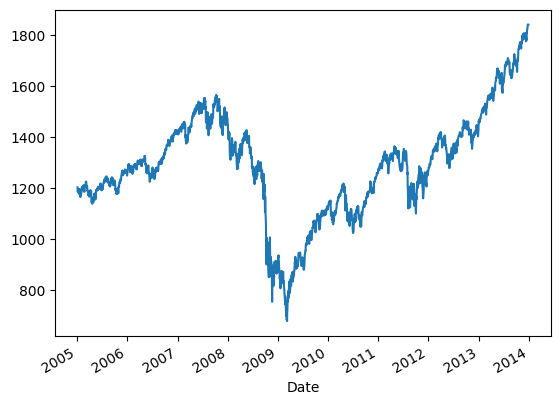

In [9]:
p.plot()

In [10]:
labels=np.log(p).diff().shift(-1).rename('label') # we need to predict next day's change
hist_returns=np.log(p).diff().rename('hist_ret') # we also want to include past returns as information

In [11]:
combined=news.merge(pd.concat([labels,hist_returns],axis=1).reset_index(),left_on='date',right_on='Date') # join the news with returns data

In [12]:
combined.drop('Date',axis=1,inplace=True)
combined=combined.sort_values('date')

In [13]:
combined.tail()

,date,title,summary,label,hist_ret
52839,2013-11-20,"Bernanke: looking forward to writing, speaking...",WASHINGTON (Reuters) - Federal Reserve Chairm...,0.008096,-0.003642
52838,2013-11-20,Mazda CEO says to begin production at key Mexi...,TOKYO (Reuters) - Mazda Motor Corp ( 7261.T )...,0.008096,-0.003642
52837,2013-11-20,J&J unit to pay $2.5 billion in U.S. hip impla...,NEW YORK (Reuters) - A unit of Johnson & John...,0.008096,-0.003642
52836,2013-11-20,Nissan to lift U.S. output of Leaf electric ca...,LOS ANGELES (Reuters) - Nissan Motor Co Ltd (...,0.008096,-0.003642
52842,2013-11-20,"Dow, S&P retreat for second day; Best Buy weighs",NEW YORK (Reuters) - U.S. stocks fell on Tues...,0.008096,-0.003642


# Load Pre-trained Model

In [ ]:
checkpoint = 'yiyanghkust/finbert-tone'
# This is a bert model fine-tuned with financial news and articles. It can output sentiments(POSTIVE, NERUTRAL and NEGATIVE) directly
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)
model_class = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
def count_words(text):
    words = text.split()
    return len(words)

# combined['summary'].apply(count_words).describe()
combined['summary'].apply(count_words).quantile(0.99)
# the word count shows MAX_SEQUENCE_LENGTH=100 may be enough

52.0

In [ ]:
MAX_SEQUENCE_LENGTH=100

In [ ]:
text=combined['summary'].to_list()
text_tokenized = tokenizer(text,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

In [ ]:
# get the output from the pretrained model
output=model_class.predict([text_tokenized['input_ids'],text_tokenized['attention_mask']])

2891/2891 [==============================] - 637s 217ms/step


In [ ]:
probs = tf.nn.softmax(output['logits'], axis=-1)

In [ ]:
combined[['prob_netrual','prob_positive','prob_negative']]=probs
combined['sentiment']=np.argmax(probs,axis=1)
combined['sentiment'].replace({2:0,0:1,1:2},inplace=True) #adjust the levels
combined['prob_diff']=combined['prob_positive']-combined['prob_negative']

In [ ]:
combined.to_csv("reuters_news_0613_with_prob.csv",index=False)

# Solution 1: averaging the sentiment for the same date

In [ ]:
sentiment_daily=combined.groupby('date')[['prob_diff','Adj Close']].mean()

In [ ]:
sentiment_daily

,prob_diff,Adj Close
date,,
2006-10-20,-0.000027,0.006133
2006-10-23,-0.024661,0.000261
2006-10-24,0.031204,0.003508
2006-10-25,0.114205,0.004951
2006-10-26,0.289727,-0.008488
...,...,...
2013-11-14,-0.036648,0.004213
2013-11-15,-0.146649,-0.003705
2013-11-18,-0.005740,-0.002045


In [ ]:
sentiment_daily['signal_pretrained']=np.sign(sentiment_daily['prob_diff'])

<Axes: xlabel='date'>

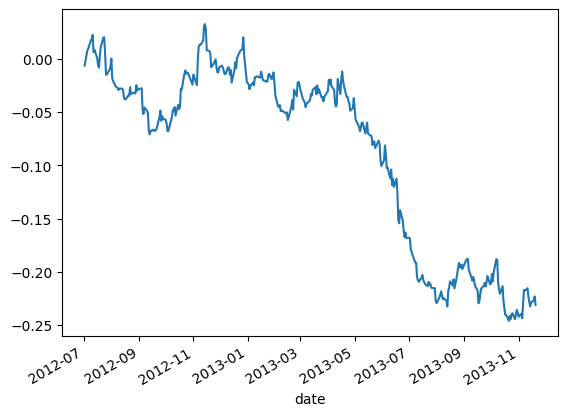

In [ ]:
(sentiment_daily['signal_pretrained']*sentiment_daily['Adj Close'])['2012-7':].cumsum().plot()

# Solution 2: fine-tuning with logits

In [ ]:
combined.groupby('date')['summary'].count().describe()

count    1784.000000
mean       51.843610
std        15.134606
min         2.000000
25%        41.000000
50%        50.000000
75%        60.000000
max       114.000000
Name: summary, dtype: float64

In [ ]:
combined.groupby('date')['summary'].count().quantile(0.95) # choose a maxium of 80 news per day

80.0

In [14]:
y=combined.groupby('date')['label'].last()

In [15]:
hist=combined.groupby('date')['hist_ret'].last()

In [25]:
MAX_X_LEN=80

In [ ]:

x_all=[]
for i in y.index:
  x=combined[combined['date']==i][['prob_negative','prob_netrual','prob_positive']].to_numpy()
  if x.shape[0]<MAX_X_LEN:
    x=x.copy()
    x.resize((MAX_X_LEN,3)) # if there are less than 80 news, we need to pad
    x_all.append(x)
  else:
    x_all.append(x[:MAX_X_LEN,:]) # if there are more than 80 news, we need to cut

In [ ]:
x_all=np.array(x_all)

In [ ]:
x_all.shape

(1784, 80, 3)

In [ ]:
np.save('padded_x_0613.npy',np.array(x_all))

In [16]:
x_all=np.load('padded_x_0613.npy')

In [17]:
WINDOW=60

In [18]:
from numpy.lib.stride_tricks import sliding_window_view
x_all_roll=sliding_window_view(x_all,WINDOW,axis=0)
x_hist_roll=sliding_window_view(hist.to_numpy(),WINDOW,axis=0)

In [19]:
train_size=round(x_all_roll.shape[0]*0.8)
train_size

1380

In [20]:
train_x=x_all[:train_size]
test_x=x_all[train_size:]

In [21]:
x_news_train=x_all_roll[:train_size]
x_hist_train=x_hist_roll[:train_size]
x_news_test=x_all_roll[train_size:]
x_hist_test=x_hist_roll[train_size:]

In [22]:
y_train=y[WINDOW-1:WINDOW+train_size-1]
y_test=y[WINDOW+train_size-1:]

In [ ]:
def create_model_with_attention(max_input_len=MAX_X_LEN,dropout=0.3,hidden_dim=32,learning_rate=0.005):
  input= tf.keras.layers.Input(shape=(max_input_len,3))
  attention=tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=MAX_X_LEN)(input,input)
  attention_flatten=tf.keras.layers.Flatten()(attention)
  hidden=tf.keras.layers.Dense(hidden_dim,)(attention_flatten)
  droput=tf.keras.layers.Dropout(dropout)(hidden)
  reg=tf.keras.layers.Dense(1)(droput)
  wan_model = tf.keras.models.Model(inputs=[input], outputs=[reg])
  wan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='mse')
  return wan_model

In [45]:
def create_model_transformer(max_input_len=MAX_X_LEN,dropout=0.3,hidden_dim=32,learning_rate=0.005):

  # two inputs source
  input_news= tf.keras.layers.Input(shape=(max_input_len,3,WINDOW))
  input_hist= tf.keras.layers.Input(shape=(WINDOW))

  # news input with attention
  attention_news=tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2,attention_axes=1)(input_news,input_news)
  attention_news_mean=tf.reduce_mean(attention_news,axis=1) # combine data within the same date
  flatten_news=tf.keras.layers.Flatten()(attention_news_mean)
  dropout_news=tf.keras.layers.Dropout(dropout)(flatten_news)

  # hist returns with attention
  attention_hist=tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2,attention_axes=1)(input_hist,input_hist)
  flatten_hist=tf.keras.layers.Flatten()(attention_hist)
  dropout_hist=tf.keras.layers.Dropout(dropout)(flatten_hist)

  # combine two inputs together
  combined=tf.concat([dropout_news,dropout_hist],axis=1)
  droput=tf.keras.layers.Dropout(dropout)(combined)
  reg=tf.keras.layers.Dense(1)(droput)
  model = tf.keras.models.Model(inputs=[input_news,input_hist], outputs=[reg])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='mse')
  return model

In [27]:
keras.backend.clear_session()

In [57]:
model_transformer=create_model_transformer()

In [58]:
model_transformer.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 80, 3, 60)]          0         []                            
                                                                                                  
 multi_head_attention_6 (Mu  (None, 80, 3, 60)            1032      ['input_7[0][0]',             
 ltiHeadAttention)                                                   'input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 tf.math.reduce_mean_3 (TFO  (None, 3, 60)                0         ['multi_head_attention_6

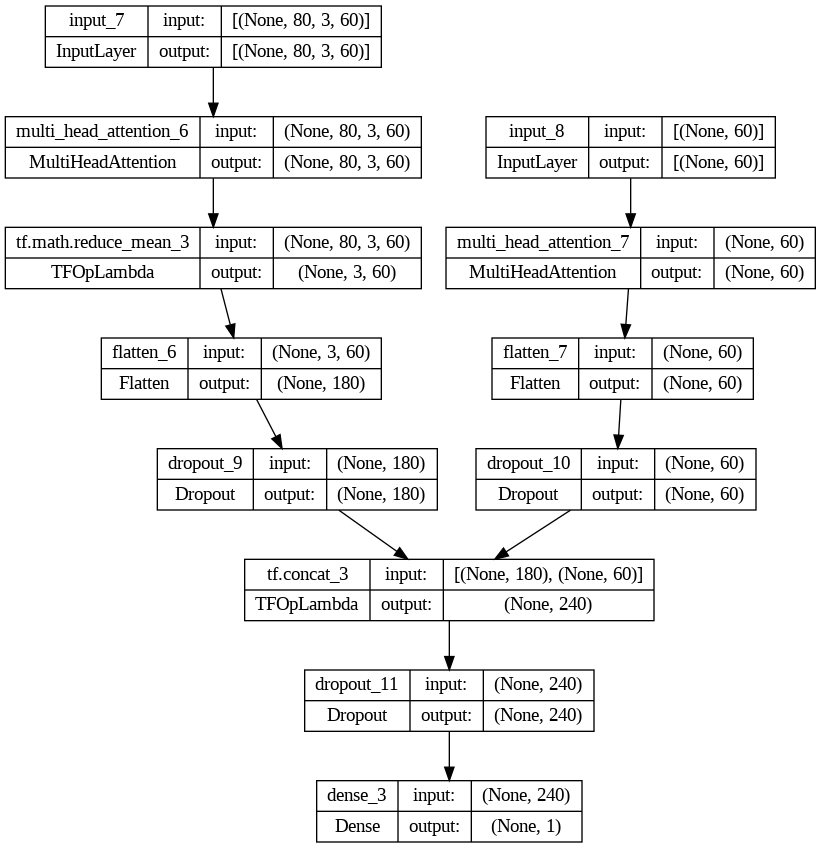

In [59]:
tf.keras.utils.plot_model(model_transformer,show_shapes=True)

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, mode="auto", restore_best_weights=True
    )

In [49]:
hist_model_using_logits=model_transformer.fit(
    [x_news_train,x_hist_train],
    y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=20,
    callbacks=early_stopping
)

Epoch 1/20
18/18 [==============================] - 4s 101ms/step - loss: 9.1981e-04 - val_loss: 3.4518e-04
Epoch 2/20
18/18 [==============================] - 2s 97ms/step - loss: 4.5423e-04 - val_loss: 2.2954e-04
Epoch 3/20
18/18 [==============================] - 2s 104ms/step - loss: 3.5265e-04 - val_loss: 2.2366e-04
Epoch 4/20
18/18 [==============================] - 2s 102ms/step - loss: 3.5347e-04 - val_loss: 2.2116e-04
Epoch 5/20
18/18 [==============================] - 1s 79ms/step - loss: 3.3806e-04 - val_loss: 2.3142e-04
Epoch 6/20
18/18 [==============================] - 1s 64ms/step - loss: 3.1084e-04 - val_loss: 2.6426e-04
Epoch 7/20
18/18 [==============================] - 1s 65ms/step - loss: 3.1379e-04 - val_loss: 2.4307e-04
Epoch 8/20
18/18 [==============================] - 1s 65ms/step - loss: 2.8805e-04 - val_loss: 2.3796e-04
Epoch 9/20
18/18 [==============================] - 1s 64ms/step - loss: 2.8956e-04 - val_loss: 2.4256e-04


<Axes: >

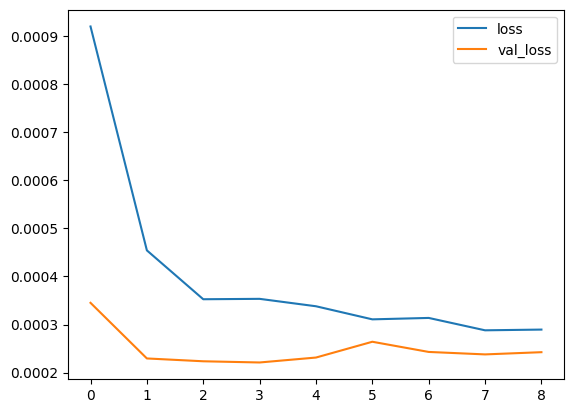

In [50]:
pd.DataFrame(hist_model_using_logits.history).plot()

In [51]:
predicts=model_transformer.predict([x_news_test,x_hist_test])

11/11 [==============================] - 0s 26ms/step


In [ ]:
model_with_attention.evaluate(test_x,test_y)

12/12 [==============================] - 0s 11ms/step - loss: 0.0011


0.0011049157474189997

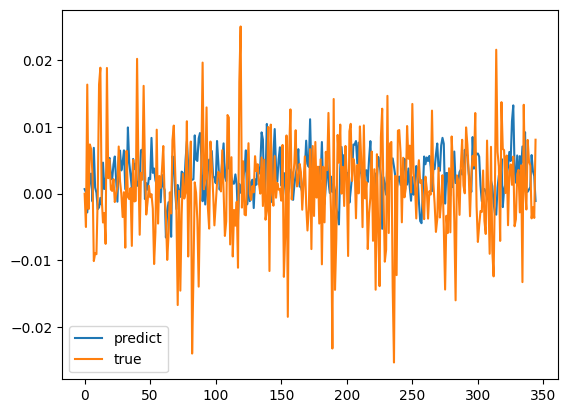

In [52]:
plt.plot(predicts,label='predict')
plt.plot(y_test.to_numpy(),label='true')
plt.legend()

In [53]:
test_y_df=pd.DataFrame(y[WINDOW+train_size-1:])

In [54]:
test_y_df['predict']=predicts

In [55]:
test_y_df['pos_quantile']=pd.qcut(test_y_df['predict'],[0,0.2,0.8,1],labels=False)-1
test_y_df['pos_sign']=np.sign(test_y_df['predict'])

In [56]:
test_y_df.corr()

,label,predict,pos_quantile,pos_sign
label,1.000000,-0.020940,-0.017997,-0.041387
predict,-0.020940,1.000000,0.880737,0.644143
pos_quantile,-0.017997,0.880737,1.000000,0.681115
pos_sign,-0.041387,0.644143,0.681115,1.000000


<Axes: xlabel='date'>

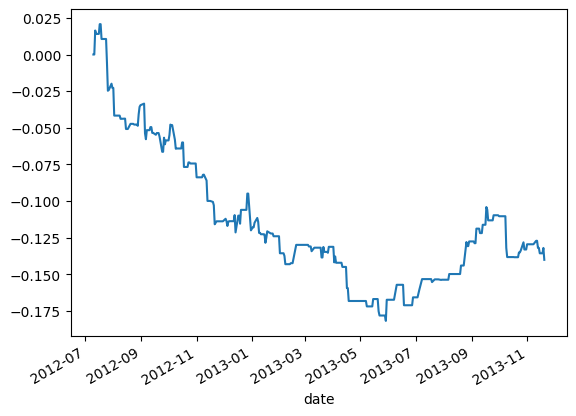

In [41]:
(test_y_df['pos_quantile']*test_y_df['label']).cumsum().plot()

In [ ]:
test_y_df.to_csv('shallow_fine_tune_0613.csv')

# Solution 3: fine-tune with pooler

## Get the pooler output for each news

In [ ]:
def extract_pooler(model):
  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')
  input={'input_ids': input_ids, 'attention_mask': attention_mask}
  pooler_layer=model(input)['pooler_output']
  extract_model = tf.keras.Model(inputs=[input], outputs=[pooler_layer])
  return extract_model

In [ ]:
extract_model=extract_pooler(model)

In [ ]:
output=extract_model.predict([text_tokenized['input_ids'],text_tokenized['attention_mask']])

2891/2891 [==============================] - 633s 218ms/step


In [ ]:
output.shape

(92489, 768)

In [ ]:
np.save('pooler_output',output)

## padding the news to 50 per day

In [ ]:
y=combined.groupby('date')['label'].last()

In [ ]:
hist=combined.groupby('date')['hist_ret'].last().to_numpy()

In [ ]:
MAX_X_LEN=50
# we basically follow the process before, only this time the input has dim of 768 instead of 3, so we need to shorten the num of news per day


In [ ]:
x_all=[]
for i in y.index:
  x=output[combined['date']==i]
  if x.shape[0]<MAX_X_LEN:
    x=x.copy()
    x.resize((MAX_X_LEN,768))
    x_all.append(x)
  else:
    x_all.append(x[:MAX_X_LEN,:])

In [ ]:
x_all=np.array(x_all)

In [ ]:
x_all.shape

(1784, 50, 768)

In [ ]:
np.save('padded_pooler_x_0613.npy',x_all)

In [ ]:
x_all=np.load('padded_pooler_x_0613.npy')

In [ ]:
WINDOW=60

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
x_all_roll=sliding_window_view(x_all,WINDOW,axis=0)
x_hist_roll=sliding_window_view(hist,WINDOW,axis=0)
labels=y[WINDOW-1:].to_numpy()

In [ ]:
assert x_all_roll.shape[0]==x_hist_roll.shape[0]==labels.shape[0]

In [ ]:
import math
class RollingGenerator(tf.keras.utils.Sequence):

    def __init__(self, x_news, x_hist, y, batch_size=32):
        self.x_news, self.x_hist,self.y = x_news, x_hist, y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.x_news.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, self.x_news.shape[0])
        batch_x_news = self.x_news[low:high]
        batch_x_hist=self.x_hist[low:high]
        batch_y = self.y[low:high]

        return [batch_x_news,batch_x_hist],batch_y

In [ ]:
total_size = labels.shape[0]
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)

train_ds=RollingGenerator(x_all_roll[:train_size],x_hist_roll[:train_size],labels[:train_size])
val_ds=RollingGenerator(x_all_roll[train_size:train_size+val_size],x_hist_roll[train_size:train_size+val_size],labels[train_size:train_size+val_size])
test_ds=RollingGenerator(x_all_roll[train_size+val_size:],x_hist_roll[train_size+val_size:],labels[train_size+val_size:])

In [ ]:
train_size=round(x_all_roll.shape[0]*0.8)
train_size

1380

In [ ]:
x_news_train=x_all_roll[:train_size]
x_hist_train=x_hist_roll[:train_size]
x_news_test=x_all_roll[train_size:]
x_hist_test=x_hist_roll[train_size:]

In [ ]:
y_train=y[WINDOW-1:WINDOW+train_size-1].to_numpy()
y_test=y[WINDOW+train_size-1:].to_numpy()

In [ ]:
def create_model_with_attention(max_input_len=MAX_X_LEN,dropout=0.3,hidden_dim=32,learning_rate=0.005):
  input= tf.keras.layers.Input(shape=(max_input_len,768))
  attention=SelfAttentionLayer(units=64,input_shape=(max_input_len,768))(input)
  attention_flatten=tf.keras.layers.Flatten()(attention)
  # hidden=tf.keras.layers.Dense(hidden_dim,)(attention_flatten)
  droput=tf.keras.layers.Dropout(dropout)(attention_flatten)
  reg=tf.keras.layers.Dense(1)(droput)
  wan_model = tf.keras.models.Model(inputs=[input], outputs=[reg])
  wan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='mse')
  return wan_model

In [ ]:
def create_model_with_attention(max_input_len=MAX_X_LEN,dropout=0.3,hidden_dim=32,learning_rate=0.005):
  input= tf.keras.layers.Input(shape=(max_input_len,768))
  attention=tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=MAX_X_LEN)(input,input)
  attention_flatten=tf.reduce_mean(attention,axis=1)
  hidden=tf.keras.layers.Dense(hidden_dim,)(attention_flatten)
  droput=tf.keras.layers.Dropout(dropout)(hidden)
  reg=tf.keras.layers.Dense(1)(droput)
  wan_model = tf.keras.models.Model(inputs=[input], outputs=[reg])
  wan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='mse')
  return wan_model

In [ ]:
model_with_attention=create_model_with_attention()

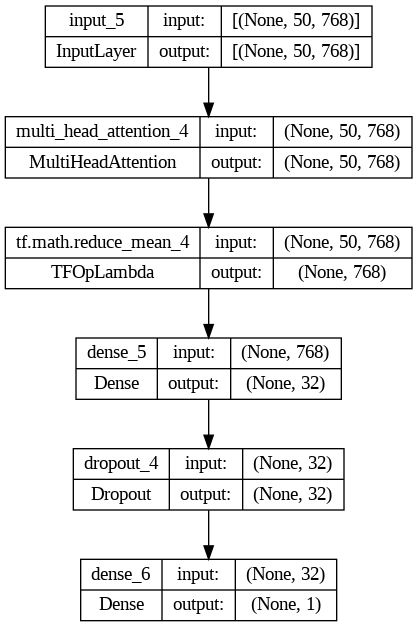

In [ ]:
tf.keras.utils.plot_model(model_with_attention,show_shapes=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, mode="auto", restore_best_weights=True
    )

In [ ]:
hist_model_using_logits=model_with_attention.fit(
    train_x,
    train_y,
    validation_split=0.2,
    batch_size=128,
    epochs=50,
    callbacks=early_stopping
)

NameError: ignored

<Axes: >

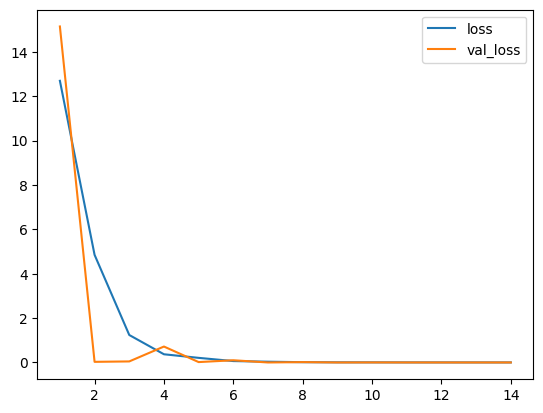

In [ ]:
pd.DataFrame(hist_model_using_logits.history)[1:].plot()

In [ ]:
predicts=model_with_attention.predict(test_x)

12/12 [==============================] - 0s 4ms/step


In [ ]:
model_with_attention.evaluate(test_x,test_y)

12/12 [==============================] - 0s 7ms/step - loss: 9.0133e-05


9.01332387002185e-05

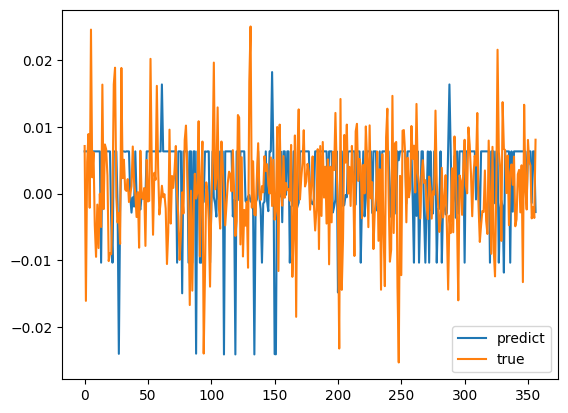

In [ ]:
plt.plot(predicts,label='predict')
plt.plot(test_y,label='true')
plt.legend()

In [ ]:
test_y_df=pd.DataFrame(y[train_size:])

In [ ]:
test_y_df['predict']=predicts

In [ ]:
test_y_df['pos_quantile']=pd.qcut(test_y_df['predict'],[0,0.2,0.8,1],labels=False)-1
test_y_df['pos_sign']=np.sign(test_y_df['predict'])

<Axes: xlabel='date'>

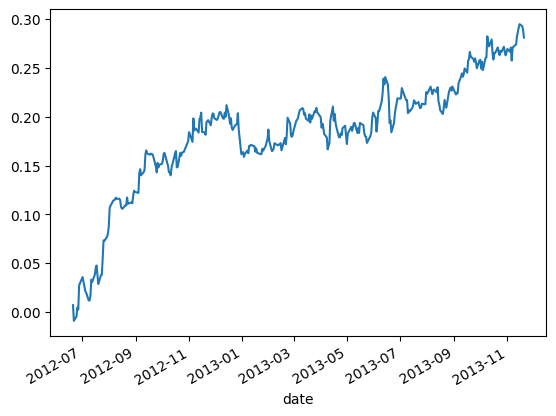

In [ ]:
(test_y_df['pos_sign']*test_y_df['Adj Close']).cumsum().plot()

In [ ]:
test_y_df.corr()

,Adj Close,predict,pos_quantile,pos_sign
Adj Close,1.000000,0.097523,0.079569,0.078949
predict,0.097523,1.000000,0.789175,0.821143
pos_quantile,0.079569,0.789175,1.000000,0.649046
pos_sign,0.078949,0.821143,0.649046,1.000000


In [ ]:
test_y_df.to_csv('deep_fine_tune_0613_2nd.csv')

In [ ]:
def create_model_transformer(max_input_len=MAX_X_LEN,dropout=0.3,hidden_dim=32,learning_rate=0.005):


  # two inputs source
  input_news= tf.keras.layers.Input(shape=(max_input_len,768,WINDOW))
  input_hist= tf.keras.layers.Input(shape=(WINDOW,))

  # news input with attention
  attention_news=tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4,attention_axes=1)(input_news,input_news)
  attention_news_mean=tf.reduce_mean(attention_news,axis=1) # combine data within the same date
  attention_news_token=tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2,attention_axes=2)(attention_news_mean,attention_news_mean)
  attention_news_token_mean=tf.reduce_mean(attention_news_token,axis=2)
  # flatten_news=tf.keras.layers.Flatten()(attention_news_token_mean)
  flatten_news=tf.keras.layers.Normalization()(attention_news_token_mean)
  dropout_news=tf.keras.layers.Dropout(0.5)(flatten_news)

  # hist returns with attention
  attention_hist=tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2,attention_axes=1)(input_hist,input_hist)
  # flatten_hist=tf.keras.layers.Flatten()(attention_hist)
  flatten_hist=tf.keras.layers.Normalization()(attention_hist)
  dropout_hist=tf.keras.layers.Dropout(dropout)(flatten_hist)

  # combine two inputs together
  combined=tf.concat([dropout_news,dropout_hist],axis=1)
  hidden=tf.keras.layers.Dense(32)(combined)
  droput=tf.keras.layers.Dropout(dropout)(hidden)
  reg=tf.keras.layers.Dense(1)(droput)
  model = tf.keras.models.Model(inputs=(input_news,input_hist), outputs=[reg])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='mse')
  return model

In [ ]:
keras.backend.clear_session()

In [ ]:
model_transformer=create_model_transformer()

In [ ]:
model_transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 768, 60)]        0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 50, 768, 60)          2004      ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 768, 60)              0         ['multi_head_attention[0][0]']
 ambda)                                                                                           
                                                                                              

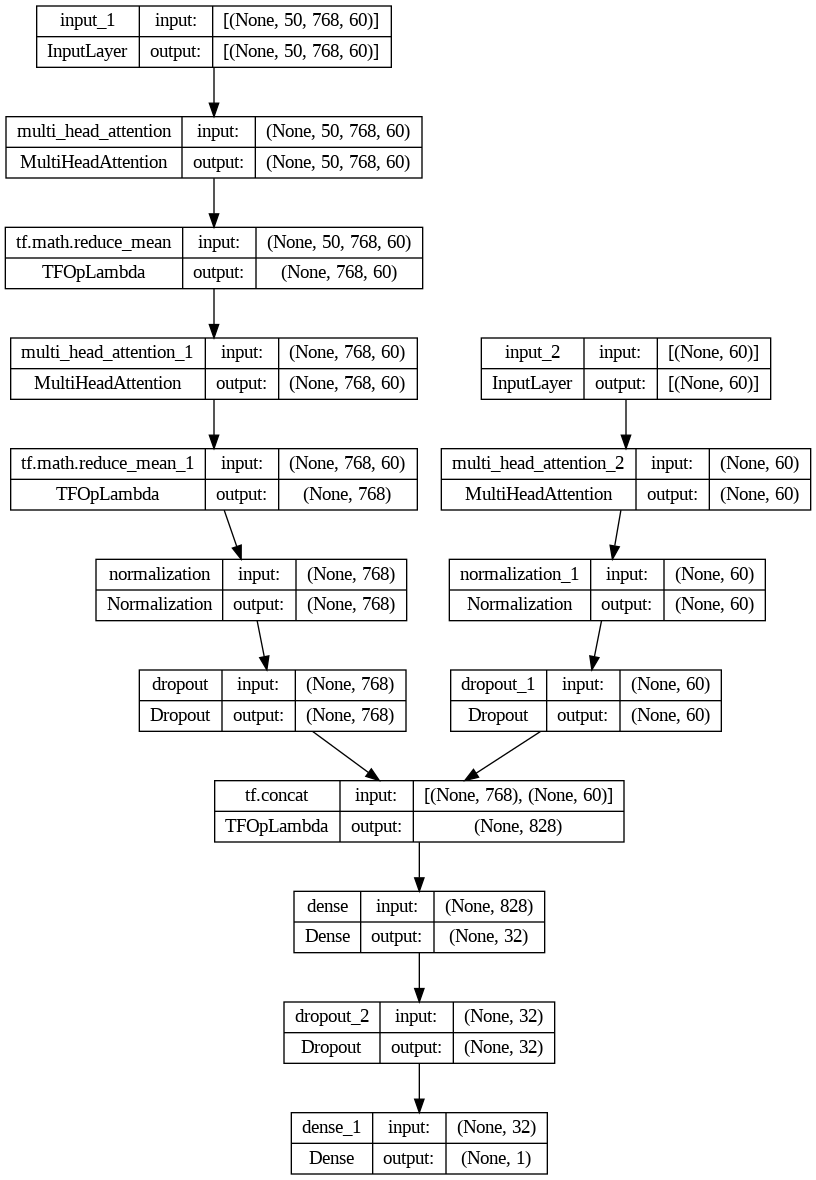

In [ ]:
tf.keras.utils.plot_model(model_transformer,show_shapes=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, mode="auto", restore_best_weights=True
    )

## train the model

In [ ]:
hist_model_using_logits=model_transformer.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=20,
    callbacks=early_stopping
)

Epoch 1/20
38/38 [==============================] - 26s 568ms/step - loss: 0.0021 - val_loss: 2.1111e-04
Epoch 2/20
38/38 [==============================] - 21s 553ms/step - loss: 3.3404e-04 - val_loss: 1.1468e-04
Epoch 3/20
38/38 [==============================] - 27s 701ms/step - loss: 3.0669e-04 - val_loss: 1.2342e-04
Epoch 4/20
38/38 [==============================] - 23s 615ms/step - loss: 3.0253e-04 - val_loss: 1.2120e-04
Epoch 5/20
38/38 [==============================] - 21s 560ms/step - loss: 3.0290e-04 - val_loss: 1.4873e-04
Epoch 6/20
38/38 [==============================] - 22s 565ms/step - loss: 3.1553e-04 - val_loss: 1.3014e-04
Epoch 7/20
38/38 [==============================] - 22s 575ms/step - loss: 2.9835e-04 - val_loss: 1.2124e-04


<Axes: >

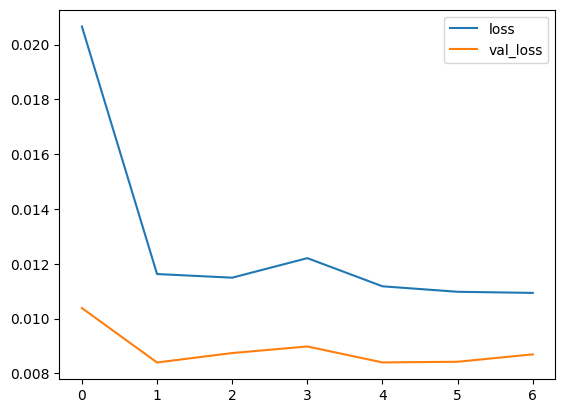

In [ ]:
pd.DataFrame(hist_model_using_logits.history).plot()

In [ ]:
predicts=model_transformer.predict(test_ds)

11/11 [==============================] - 5s 440ms/step


In [ ]:
np.save('predicts_temp.npy',predicts)

In [ ]:
model_transformer.evaluate(test_ds)

12/12 [==============================] - 2s 177ms/step - loss: 0.0057


0.0056875403970479965

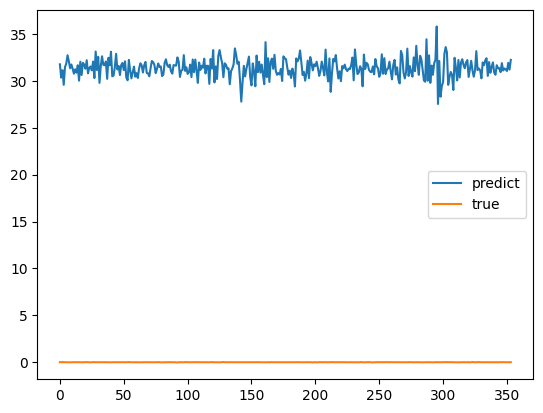

In [ ]:
plt.plot(predicts/predicts.std(),label='predict')
plt.plot(labels[train_size+val_size:],label='true')
plt.legend()

In [ ]:
test_y_df=pd.DataFrame(y[train_size+val_size+WINDOW-1:])

In [ ]:
test_y_df['predict']=predicts

In [ ]:
test_y_df['pos_quantile']=pd.qcut(test_y_df['predict'],[0,0.2,0.8,1],labels=False)-1
test_y_df['pos_sign']=np.sign(test_y_df['predict'])

In [ ]:
test_y_df.corr()

,label,predict,pos_quantile,pos_sign
label,1.000000,-0.040978,-0.018002,NaN
predict,-0.040978,1.000000,0.866222,NaN
pos_quantile,-0.018002,0.866222,1.000000,NaN
pos_sign,NaN,NaN,NaN,NaN


<Axes: xlabel='date'>

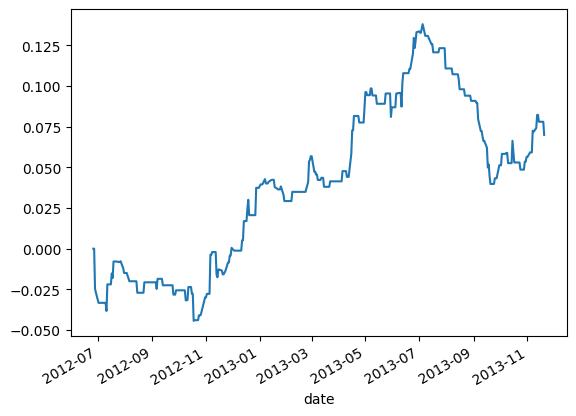

In [ ]:
(test_y_df['pos_quantile']*test_y_df['label']).cumsum().plot()